# Visualization with UP-DETR
In this notebook, we show the visualization result with the UP-DETR pre-training model (without any annotations). 

## Prepare code and models
clone the code from github and download the model file from google drive

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1JhL1uwNJCaxMrIUx7UzQ3CMCHqmZpCnn' # URL id for the UP-DETR pre-training model. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('up-detr-pre-training-60ep-imagenet.pth')

In [2]:
!git clone https://github.com/dddzg/up-detr.git
!mv ./up-detr/* ./

Cloning into 'up-detr'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 98 (delta 45), reused 47 (delta 12), pack-reused 0
Unpacking objects: 100% (98/98), done.


## Initialize the model
initialize the model with the pre-training model.

In [3]:
import torch

from models.backbone import Backbone, Joiner
from models.detr import DETR, PostProcess
from models.position_encoding import PositionEmbeddingSine
from models.segmentation import DETRsegm, PostProcessPanoptic
from models.transformer import Transformer
from models.updetr import UPDETR
import torchvision.transforms as T
torch.set_grad_enabled(False)


def build_updetr(num_classes=2):
    hidden_dim = 256
    backbone = Backbone("resnet50", train_backbone=False, return_interm_layers=False, dilation=False)
    pos_enc = PositionEmbeddingSine(hidden_dim // 2, normalize=True)
    backbone_with_pos_enc = Joiner(backbone, pos_enc)
    backbone_with_pos_enc.num_channels = backbone.num_channels
    transformer = Transformer(d_model=hidden_dim, normalize_before=True, return_intermediate_dec=True)
    model = UPDETR(
            backbone_with_pos_enc,
            transformer,
            num_classes=num_classes,
            num_queries=100,
            num_patches=10,
            feature_recon=False,
            query_shuffle=False)
    return model

model = build_updetr()
checkpoint = torch.load('up-detr-pre-training-60ep-imagenet.pth',map_location='cpu')['model']
msg = model.load_state_dict(checkpoint,strict=False)
model.eval()
print(msg)

Downloading: "https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_800ep_pretrain.pth.tar


  0%|          | 0.00/108M [00:00<?, ?B/s]

_IncompatibleKeys(missing_keys=[], unexpected_keys=['feature_align.layers.0.weight', 'feature_align.layers.0.bias', 'feature_align.layers.1.weight', 'feature_align.layers.1.bias'])


## Preprare image
Download the image and pack it into input tensor format. 

In [4]:
import matplotlib.pyplot as plt
# standard PyTorch mean-std input image normalization
image_transform = T.Compose([
    T.Resize(420),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
patch_aug_transform = T.Compose([
    T.RandomApply([
      T.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    T.RandomGrayscale(p=0.2),
])
patch_transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    patch_id = 0
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'patch_{patch_id}: {p[cl]:0.2f}'
        patch_id += 1
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [5]:
from PIL import Image
import random
random.seed(23333)
import requests
# image in the paper
url = 'https://p0.piqsels.com/preview/126/30/480/animals-cats-cute-feline.jpg'
image = Image.open(requests.get(url, stream=True).raw)
patches = []
# To make visualization beautiful, we manually crop some reasonable objects here.
patches = [image.crop((19,112,193,284)),image.crop((238,19,399,403)),image.crop((408,80,579,249)),image.crop((540,141,772,349)),image.crop((728,78,872,214)),image.crop((25,19,872,411))]
# You can also try to randomly crop "objects".
# w,h = image.size
# for i in range(5):
#   x = random.randint(0,w-32) # avoid too small objects.
#   y = random.randint(0,h-32)
#   xx = random.randint(x+32,w)
#   yy = random.randint(y+32,h)
#   patches.append(image.crop((x, y, xx, yy)))

# Make the task difficult by applying data augmentations.
patches = [patch_aug_transform(patch) for patch in patches]



##Model forward and display


/content/models/position_encoding.py:47: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


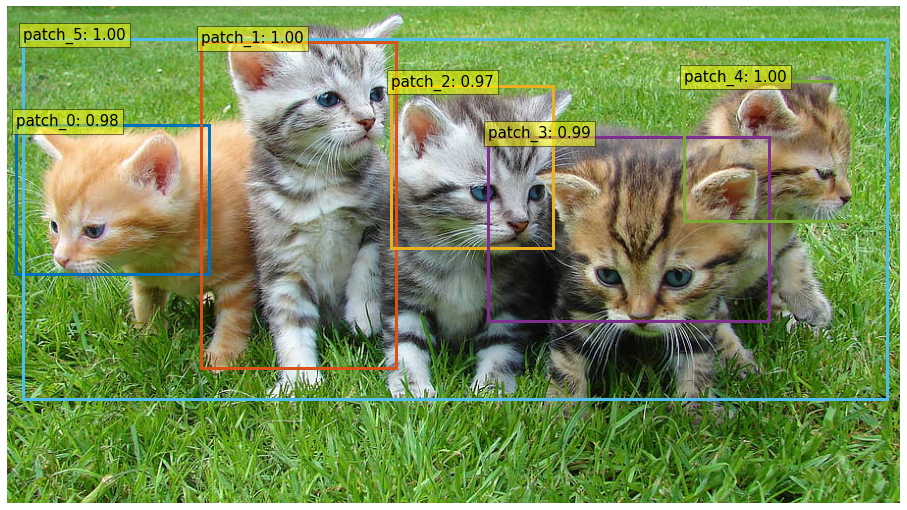

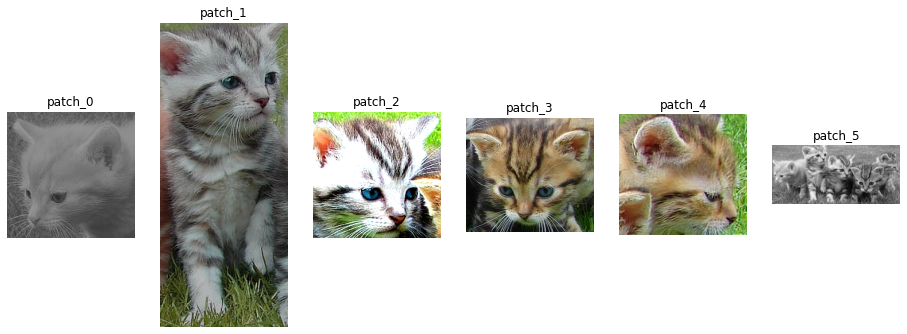

In [6]:
image_tensor = image_transform(image).unsqueeze(0)
patches_tensor = torch.stack([patch_transform(patch) for patch in patches], dim=0).unsqueeze(0)
outputs = model(image_tensor,patches_tensor)

probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
max_probas = probas.max(-1).values
keep = torch.zeros(max_probas.shape[0],dtype=torch.bool)

# 10 object queries are assigned into a group.
# get argmax() index for every 10 object queries.
for i in range(patches_tensor.shape[1]):
  keep[i*10+max_probas[i*10:(i+1)*10].argmax().item()] = 1

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], image.size)
plot_results(image, probas[keep], bboxes_scaled)

# show patches
fig = plt.figure(figsize=(16,len(patches))) 
for i,patch in enumerate(patches):
  fig.add_subplot(1, len(patches), i+1)
  plt.imshow(patch) 
  plt.axis('off') 
  plt.title(f"patch_{i}") 